# SentenceBERT 한국어 문장 클러스터링


In [ ]:
# GPU 변경, 런타임 - 런타임 유형 변경 - GPU
!nvidia-smi

Wed Apr  6 07:51:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |   1966MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# SentenceBERT Install

In [ ]:
!pip install -q -U sentence-transformers

# Embedding Example

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('jhgan/ko-sroberta-multitask')

sentences = ['안녕하세요?', '조용식입니다.']
embeddings = model.encode(sentences)
print(embeddings)

[[-0.3751042  -0.77338403  0.59277123 ...  0.57923526  0.32683486
  -0.65089667]
 [-0.04237254  0.07960183  0.12686096 ...  0.04116577  0.08316256
   0.22303988]]


# clustering sample code 

In [ ]:
from sklearn.cluster import KMeans

sentences = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.',
          '한 남자가 파스타를 먹는다.',
          '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
          '치타가 들판을 가로 질러 먹이를 쫓는다.']

embeddings = model.encode(sentences)

num_clusters = 5 
kmeans_clustering_model = KMeans(n_clusters= num_clusters)
kmeans_clustering_model.fit(embeddings)
cluster_assigment = kmeans_clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assigment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences) :
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['한 여자가 바이올린을 연주한다.', '원숭이 한 마리가 드럼을 연주한다.', '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.']

Cluster  2
['한 남자가 음식을 먹는다.', '한 남자가 빵 한 조각을 먹는다.', '한 남자가 파스타를 먹는다.']

Cluster  3
['한 남자가 말을 탄다.', '두 남자가 수레를 숲 속으로 밀었다.', '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.']

Cluster  4
['그 여자가 아이를 돌본다.']

Cluster  5
['치타 한 마리가 먹이 뒤에서 달리고 있다.', '치타가 들판을 가로 질러 먹이를 쫓는다.']



# 뱀파이어 서바이벌 리뷰 크롤링

In [ ]:
import requests
import time

In [ ]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
        'json' : 1,
        'filter' : 'all',
        'language' : 'koreana',
        'day_range' : 9223372036854775807,
        'review_type' : 'all',
        'purchase_type' : 'all'
    }

    while n > 0:
        time.sleep(2)
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [ ]:
reviews = get_n_reviews(1794680, 10000)

reviews[:5]

# 전처리 시작

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(reviews)
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
0,108809382,"{'steamid': '76561198091462002', 'num_games_ow...",koreana,한국어 패치 22-02-06 설치용 ver. (게임 베타 버전은 한국어 지원)\nh...,1643193984,1645381413,True,1024,82,0.974620401859283447,24,True,False,True,NaN,NaN
1,108114603,"{'steamid': '76561198068425937', 'num_games_ow...",koreana,재미있다. 더블클릭이 부담되는 게임 불감증을 날려줬다.\n금색상자 열때 어께춤이 자...,1642312885,1644718436,True,425,18,0.958003461360931396,0,True,False,True,NaN,NaN
2,108462827,"{'steamid': '76561198003696044', 'num_games_ow...",koreana,"""상자가""\n\n\n""5줄기?!""",1642775192,1642775192,True,354,254,0.945378601551055908,2,True,False,True,NaN,NaN
3,108186185,"{'steamid': '76561198395529225', 'num_games_ow...",koreana,구매하고 한 판만 해보셈\n잠깐 했는데 아침임,1642396952,1642396952,True,201,64,0.937637865543365479,6,True,False,True,NaN,NaN
4,108208515,"{'steamid': '76561198996956743', 'num_games_ow...",koreana,infinity mod plz,1642431780,1642431780,True,186,5,0.913768410682678223,0,True,False,True,NaN,NaN


In [ ]:
# 한글 제거, 작은따음표 제거, 연속 공백 제거, 좌우 공백 제거, 최대 255로 제한

df['review'] = df['review'] \
  .replace(r'[^가-힣 ]', ' ', regex=True) \
  .replace("'", '') \
  .replace(r'\s+', ' ', regex=True) \
  .str.strip() \
  .str[:255]

df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
0,108809382,"{'steamid': '76561198091462002', 'num_games_ow...",koreana,한국어 패치 설치용 게임 베타 버전은 한국어 지원 특정 무기 특정 패시브 스킬 이상...,1643193984,1645381413,True,1024,82,0.974620401859283447,24,True,False,True,NaN,NaN
1,108114603,"{'steamid': '76561198068425937', 'num_games_ow...",koreana,재미있다 더블클릭이 부담되는 게임 불감증을 날려줬다 금색상자 열때 어께춤이 자동으로...,1642312885,1644718436,True,425,18,0.958003461360931396,0,True,False,True,NaN,NaN
2,108462827,"{'steamid': '76561198003696044', 'num_games_ow...",koreana,상자가 줄기,1642775192,1642775192,True,354,254,0.945378601551055908,2,True,False,True,NaN,NaN
3,108186185,"{'steamid': '76561198395529225', 'num_games_ow...",koreana,구매하고 한 판만 해보셈 잠깐 했는데 아침임,1642396952,1642396952,True,201,64,0.937637865543365479,6,True,False,True,NaN,NaN
4,108208515,"{'steamid': '76561198996956743', 'num_games_ow...",koreana,,1642431780,1642431780,True,186,5,0.913768410682678223,0,True,False,True,NaN,NaN


In [ ]:
# 아무것도 안써져있는거 제거 
df = df[df['review'].str.strip().astype(bool)]
print('남은 리뷰의 개수 : ', len(df))
print('')

# 리뷰 한 5개 정도 확인해보기.

# df['review'][:5]
df['review'].values.tolist()[:5]

남은 리뷰의 개수 :  8999



['한국어 패치 설치용 게임 베타 버전은 한국어 지원 특정 무기 특정 패시브 스킬 이상 상태에서 상자를 열면 무기 진화 벼락 반지 투사체 증가 로 진화 성수 아이템 획득 범위 증가 로 진화 채찍 최대 체력 증가 로 진화 마법화살 쿨타임 감소 로 진화 나이프 투사체 속도 증가 로 진화 도끼 공격 범위 증가 로 진화 부메랑 행운 증가 로 진화 성경 무기 효과 지속 시간 증가 로 진화 불화살 데미지 증가 로 진화 마늘 초당 체력 회복 로 진화 백둘기 흑둘기 로 ',
 '재미있다 더블클릭이 부담되는 게임 불감증을 날려줬다 금색상자 열때 어께춤이 자동으로 춰짐 신캐릭 추가 해금조건 누적 몬스터킬 만마리 달성시 획득 무기조합 종추가 첨 하시는분들을 위해 아이템 조합 히든캐릭터 게임 실행후 메인메뉴에서 매우빠르게 입력 성공하면 소리가 납니다 히든캐릭터 분후 등장하는 사신을 사냥하면 획득 화이팅 참고로 과 로 뱅글뱅글 돌며 사냥시도 해봤는데 일정시간이 지나면 사신이 한마리가 더 나온다',
 '상자가 줄기',
 '구매하고 한 판만 해보셈 잠깐 했는데 아침임',
 '한두판하고 끌줄알았는데 시간을 넘긴 나를발견했다 옆에서 롤하던 남편이 구경하다가 한판만 해본다고해놓고 몇판째 하고있다 개빠져든다']

In [ ]:
# 간단 저장 코드 
df.to_csv('vampire_reviews_ko.csv', index=False)

# 리뷰 임베딩

In [ ]:
corpus = df['review'].values.tolist()
embeddings = model.encode(corpus)
embeddings[:3]

array([[ 0.11992339, -0.32807374, -0.23439592, ...,  0.03957505,
         0.20685571,  0.11091947],
       [-0.4382674 , -0.37216756,  0.46318018, ...,  0.3612451 ,
        -0.16910656, -0.29170856],
       [-0.5153269 , -0.25268823,  0.3356866 , ..., -0.26653308,
         0.3528243 ,  0.14837697]], dtype=float32)

# KMeans Clustering Num = 5 

In [ ]:
num_clusters = 5 
kmeans_clustering_model = KMeans(n_clusters= num_clusters)
kmeans_clustering_model.fit(embeddings)
cluster_assigment = kmeans_clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assigment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences) :
    print("Cluste %d (%d) " % (i+1, len(cluster)))
    print(cluster)
    print("") 

Cluste 1 (1753) 
['와 시간이 그냥 순식간에 훅 가네 사람들이 재밌다고하는 이유를 알겠다', '쫌 하다가 끌 줄 알았는데 벌써 시간이 지나가네', '저녁에 가벼운 마음으로 켰는데 아침에 좆됐음을 느껴벌임', '이건 당신의 돌려줘요 뭐야 내 시간 입니다', '뭐야 두세판 한거같은데 내 시간 어디갔어', '시벌 타임머신이 여기 또 있네', '시계가 고장난거 같아요', '지금 몇시지', '시간만에 엔딩 봄 쉽습니다 재미있습니다 앞으로도 할만합니다', '시간도둑', '뭐야 내 시간 돌려줘요', '아 이게 타임머신이지', '롤 대기 시간 날려줌', '시간 순삭됩니다 클리어전까지 시간정도 걸리고 충분히 재미있음 돈 하나도 안아까움', '시간 순삭됨 니들은 이런거 하지마라 후', '뭐야 내시간 돌려줘요', '실행 했다 하면 타임 슬립', '자기 전에 잠깐 했는데 새벽이네', '시간 매우 잘갑니다', '킬링타임으로 좋음', '시간순삭임', '시간동안 했다고', '시간 잘가네요', '분씩 시간가는줄 모름 무한반복', '시간때우기에 이만한게 없다', '시간삭제', '눈을 떠보니 시간이 사라졌습니다', '뭐야 내시간 돌려줘요', '킬링타임용 마약 시간이 정말 사라짐 내 시간이 정말 하찮게 느껴지지만 멈출 수 없음', '정신차리고 보니 시간', '시발 내시간 어디감', '아니 이게 이상하다 시간이 왜 벌써 이렇게 됐지', '뭐야 내 주말 돌려줘요', '원으로 시간여행가능', '뱀파이어 서바이벌하다 아내가 어디 좀 가자고 해서 이것만 좀 하고 가자고 했는데 시간이 흘렀네요', '머임 아 내 시간 돌려줘요', '제 시간이 순식간에 사라졌어요', '원으로 시간 즐긴 썰 푼다', '뭐야 내 시간 돌려줘요', '시간 죽이기', '그냥시간순삭', '아니 뭐햇다고 벌써 아침이야', '자기전에 맛만 보고 꺼야지 했는데 시간 순삭', '원 짜리 타임머신 성능 확실하네요', '내 시간 돌려줘요', '내 시간 돌려줘', '아니 시발 뭐 얼마나 재밌겠어 하고 켰는데 시간 지나있음', '새

# KMeans Clustering Num = 3

In [ ]:
num_clusters = 3 
kmeans_clustering_model = KMeans(n_clusters= num_clusters)
kmeans_clustering_model.fit(embeddings)
cluster_assigment = kmeans_clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assigment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences) :
    print("Cluste %d (%d) " % (i+1, len(cluster)))
    print(cluster)
    print("") 

Cluste 1 (2809) 
['상자가 줄기', '대체 왜 재밌음', '잘 만들었음', '개재밋음', '원의 행복', '사', '진짜존잼', '사', '꿀잼', '별로 재미있음', '은근 재밌음', '미친겜 미친겜', '오우 쒯 눈아퍼', '마성의 매력을 지닌 마늘겜 템조합 매력을 지닌 운빨겜', '무지성재미', '예상못한갓겜', '사장님이 맛있고 요리가 친절해요', '난 재미있게 했다', '가성비 오짐 존나재밌음 안질림', '재밋어', '재밌따', '중독성 있어요 추천합니다', '재미 그 자체', '꿀잼', '귯', '갓똥겜', '가성비 최강', '갓겜', '진짜 개재밋네', '해', '굿', '마약겜', '개꿀잼', '갓겜', '중독성 쩔음', '굳', '별거아닌데 재밋음', '씹가성비 갓겜', '단순한데 재미있어요', '갓 겜', '개추', '중독섬 쩐다', '갓겜', '문명과 에 이은 시간순삭겜', '아 갓겜이지', '개추', '미친 가성비 그냥 재밌음', '갓둘기 갓둘기', '재미있어요', '가성비 갓겜', '에이 일단 해봐 완전 갓겜이라니까', '재밌어요', '이거 솔직히 원 아니야', '미쳣다', '갓겜', '원의 행복', '좋아요', '혜자겜', '개꿀잼', '재밌음', '아주 굳', '사', '존잼', '뭐야 의외로 재밌잖아 너 왜 재밌는거냐', '꽤 즐거운', '존나 재밌음', '인생 최고의 원', '뭐 문명 가소롭군', '뭐지 왜 재미있지', '존내 재밌음', '넘무 재미떠', '핵 꿀 쨈', '상자', '재밌네', '나이스하다', '강추', '가격대비 상타취', '재밌어요', '진짜 개꿀잼 혜자겜입니다 무조건 구매하십쇼', '재밌음', '와', '개꿀잼', '가성비 개꿀 보기완 다르게 재밌음', '재밌네요', '진정한 핵앤슬래시', '개 갓 겜', '가성비 갓', '중독성 갑', '정말 갓겜입니다', '재미있다', '운빨 조트망 갓겟입니다 경쾌한 상자깡 음악에 흥겨움이 두 배', '굿', '재밋슴', '정말 갓겜이네요', '갓 겜', '

# WordCloud Insight

In [ ]:
!pip install -q konlpy tqdm

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 51.7 MB/s 


In [ ]:
from konlpy.tag import Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(df['review'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 8999/8999 [00:40<00:00, 222.35it/s]


41039

In [ ]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

시간 1969
게임 1915
중독성 511
수 485
원 474
것 421
가성비 412
갓겜 364
이 336
분 331
재밌음 296


In [ ]:
# 한글 폰트 다운 
!wget https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf

--2022-04-06 08:35:03--  https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf [following]
--2022-04-06 08:35:03--  https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063276 (1.0M) [application/octet-stream]
Saving to: ‘NanumSquareRoundR.ttf’

NanumSquareRoundR.t 100%[===================>]   1.01M  --.-KB/s    in 0.06s   

2022-04-06 08:35:03 (15.6 MB/s) - ‘NanumSquareRoundR.ttf’ saved [1063276

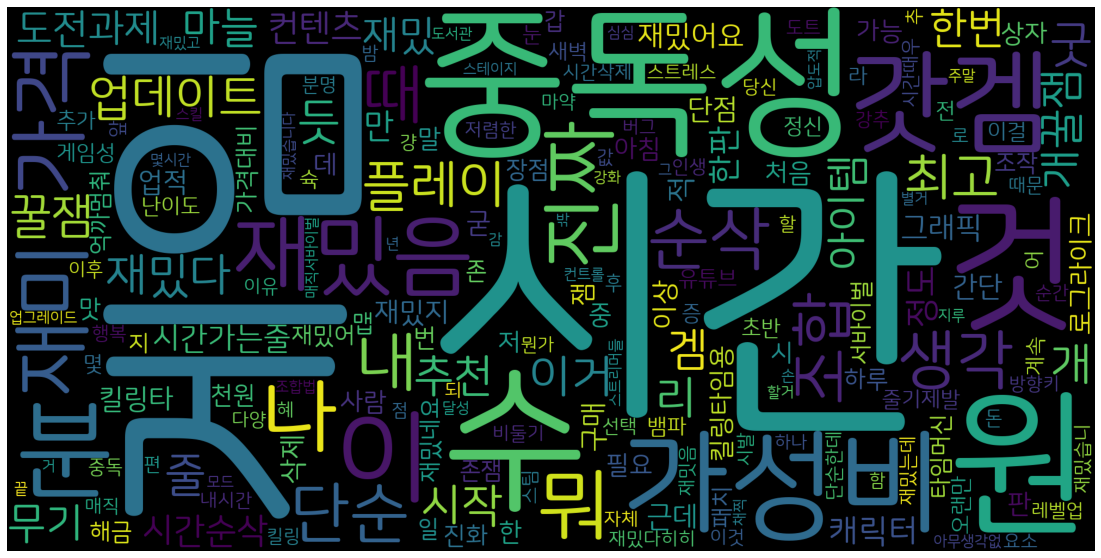

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# 긍정? 부정?

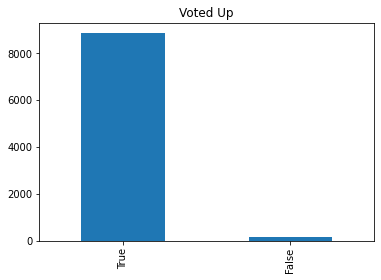

In [ ]:
df['voted_up'].value_counts().plot(kind='bar', title='Voted Up')

In [ ]:
# 매우 긍정적인 뱀파이어 서바이벌 친구..